<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/w3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [3주차] 심화과제: Pre-trained모델로 효율적인 NLP 모델 학습하기


In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 754.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

## [MY CODE] 학습결과 저장을 위한 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] multi_nli 데이터셋 적용

train은 1만개만 적용

In [4]:
ds = load_dataset("nyu-mll/multi_nli")
train_ds = ds['train'].select(range(10000))


def collate_fn(batch):
  max_len = 512
  texts_1, texts_2, labels = [], [], []
  for row in batch:
      labels.append(row['label'])
      texts_1.append(row['premise'])
      texts_2.append(row['hypothesis'])

  # 두 문장을 [SEP] 토큰으로 구분하여 tokenization
  encoded = tokenizer(
      texts_1,
      text_pair=texts_2,  # 두 번째 문장
      padding=True,
      truncation=True,
      max_length=max_len
  )

  input_ids = torch.LongTensor(encoded.input_ids)
  attention_mask = torch.LongTensor(encoded.attention_mask)
  labels = torch.LongTensor(labels)

  return input_ids, attention_mask, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['validation_matched'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.89k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/4.94M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/5.10M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

## [MY CODE] EDA

데이터셋 구조:
DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})

학습 데이터 예시:
{'promptID': [31193, 101457, 134793], 'pairID': ['31193n', '101457e', '134793e'], 'premise': ['Conceptually cream skimming has two basic dimensions - product and geography.', 'you know during the season and i guess at at your level uh you lose them to the nex

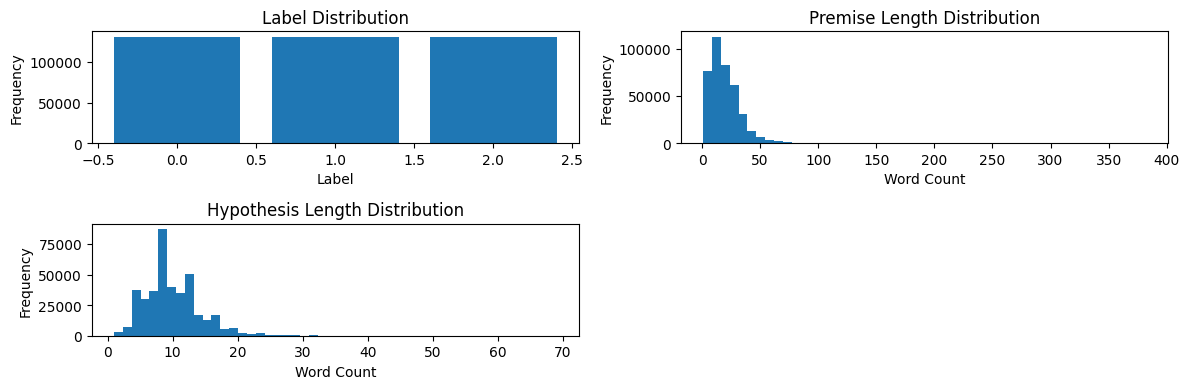

In [9]:
# 데이터셋 구조 확인
print("데이터셋 구조:")
print(ds)

# 학습 데이터 샘플 확인
print("\n학습 데이터 예시:")
print(ds['train'][:3])

# 레이블 분포 확인
from collections import Counter
labels = [example['label'] for example in ds['train']]
label_dist = Counter(labels)
print("\n레이블 분포:")
print(label_dist)

# Premise 길이 분석
premise_lengths = [len(example['premise'].split()) for example in ds['train']]
print("\nPremise 길이 통계:")
print(f"평균 길이: {sum(premise_lengths)/len(premise_lengths):.2f}")
print(f"최대 길이: {max(premise_lengths)}")
print(f"최소 길이: {min(premise_lengths)}")

# Hypothesis 길이 분석
hypothesis_lengths = [len(example['hypothesis'].split()) for example in ds['train']]
print("\nHypothesis 길이 통계:")
print(f"평균 길이: {sum(hypothesis_lengths)/len(hypothesis_lengths):.2f}")
print(f"최대 길이: {max(hypothesis_lengths)}")
print(f"최소 길이: {min(hypothesis_lengths)}")

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 레이블 분포 시각화
plt.subplot(2, 2, 1)
plt.bar(label_dist.keys(), label_dist.values())
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Premise 길이 분포 시각화
plt.subplot(2, 2, 2)
plt.hist(premise_lengths, bins=50)
plt.title('Premise Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Hypothesis 길이 분포 시각화
plt.subplot(2, 2, 3)
plt.hist(hypothesis_lengths, bins=50)
plt.title('Hypothesis Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


토큰 길이 통계:
평균 토큰 길이: 39.92
최대 토큰 길이: 444
최소 토큰 길이: 5


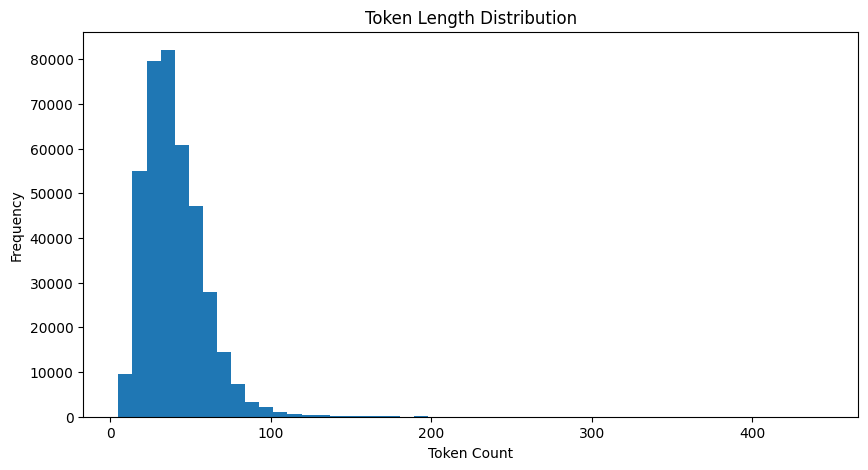

50번째 백분위수: 37
75번째 백분위수: 50
90번째 백분위수: 63
95번째 백분위수: 73
99번째 백분위수: 99


In [10]:
# 토큰 길이 분석
token_lengths = []
for example in ds['train']:
    tokens = tokenizer.encode(
        example['premise'],
        example['hypothesis'],
        add_special_tokens=True,
    )
    token_lengths.append(len(tokens))

# 토큰 길이 통계
print("\n토큰 길이 통계:")
print(f"평균 토큰 길이: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"최대 토큰 길이: {max(token_lengths)}")
print(f"최소 토큰 길이: {min(token_lengths)}")

# 토큰 길이 분포 시각화
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# 토큰 길이 백분위수 확인
import numpy as np
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}번째 백분위수: {np.percentile(token_lengths, p):.0f}")


In [11]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

## [MY CODE] TextClassifier

In [5]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 3)

  def forward(self, x, attention_mask):
    x = self.encoder(x, attention_mask=attention_mask)['last_hidden_state']
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
for param in model.encoder.parameters():
  param.requires_grad = False

## [MY CODE] CrossEntropyLoss 사용

In [7]:
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=lr)
n_epochs = 10
train_losses = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, attention_mask, labels = data
    inputs, attention_mask, labels = inputs.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

    preds = model(inputs, attention_mask=attention_mask)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    train_losses.append(total_loss)

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

Epoch   0 | Train Loss: 169.05655020475388
Epoch   1 | Train Loss: 165.09062558412552
Epoch   2 | Train Loss: 162.74251002073288
Epoch   3 | Train Loss: 161.03511637449265
Epoch   4 | Train Loss: 160.08188831806183
Epoch   5 | Train Loss: 159.5205442905426
Epoch   6 | Train Loss: 158.5124072432518
Epoch   7 | Train Loss: 157.62649142742157
Epoch   8 | Train Loss: 157.63869363069534
Epoch   9 | Train Loss: 157.10597771406174


In [8]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/HH_w3/bert_model.pt'
losses_save_path = '/content/drive/MyDrive/Colab Notebooks/HH_w3/bert_losses.npy'

torch.save(model.state_dict(), model_save_path)

import numpy as np
np.save(losses_save_path, np.array(train_losses))

## [MY CODE] 분류문제에 맞게 argmax 적용

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, attention_mask, labels = data
    inputs, attention_mask, labels = inputs.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

    preds = model(inputs, attention_mask=attention_mask)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.520 | Test acc: 0.477


## [LOG] 테스트 정확도 47.7%

## [MY CODE] Pretrained 모델 없는 Transformer

In [10]:
class TransformerFromScratch(nn.Module):
    def __init__(self,
                 vocab_size,      # tokenizer의 vocab_size
                 d_model=32,
                 n_heads=4,
                 n_layers=5,
                 d_ff=128,
                 max_len=512,
                 n_classes=3):
        super().__init__()

        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)

        # Classification head
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x, attention_mask):
        # Position indices
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        positions = positions.clamp(0, min(self.position_embedding.num_embeddings - 1, x.size(1) -1))


        # Embeddings
        x = self.token_embedding(x) + self.position_embedding(positions)

        # Attention mask 변환 (1 -> False, 0 -> True for padding mask)
        padding_mask = (attention_mask == 0)

        # Transformer layers
        x = self.transformer(x, src_key_padding_mask=padding_mask)

        # Classification using [CLS] token (first token)
        x = self.classifier(x[:, 0])

        return x

In [11]:
scratch_model = TransformerFromScratch(
    vocab_size=tokenizer.vocab_size,
)
scratch_model = scratch_model.to('cuda')
scratch_optimizer = AdamW(scratch_model.parameters(), lr=lr)
scratch_loss_fn = nn.CrossEntropyLoss()


In [12]:
n_epochs = 10
scratch_losses = []

for epoch in range(n_epochs):
  total_loss = 0.
  scratch_model.train()
  for data in train_loader:
    scratch_model.zero_grad()
    inputs, attention_mask, labels = data
    inputs, attention_mask, labels = inputs.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

    preds = scratch_model(inputs, attention_mask=attention_mask)
    loss = scratch_loss_fn(preds, labels)
    loss.backward()
    scratch_optimizer.step()

    total_loss += loss.item()
    scratch_losses.append(total_loss)

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

Epoch   0 | Train Loss: 173.13804721832275
Epoch   1 | Train Loss: 172.56308436393738
Epoch   2 | Train Loss: 171.78204464912415
Epoch   3 | Train Loss: 167.61603671312332
Epoch   4 | Train Loss: 161.80726599693298
Epoch   5 | Train Loss: 153.31791973114014
Epoch   6 | Train Loss: 143.91000282764435
Epoch   7 | Train Loss: 133.17748361825943
Epoch   8 | Train Loss: 121.938749730587
Epoch   9 | Train Loss: 109.84796380996704


In [13]:
with torch.no_grad():
  scratch_model.eval()
  scratch_train_acc = accuracy(scratch_model, train_loader)
  scratch_test_acc = accuracy(scratch_model, test_loader)
  print(f"=========> Train acc: {scratch_train_acc:.3f} | Test acc: {scratch_test_acc:.3f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


=========> Train acc: 0.764 | Test acc: 0.390


## [LOG] Scratch 모델의 Test 정확도 39%

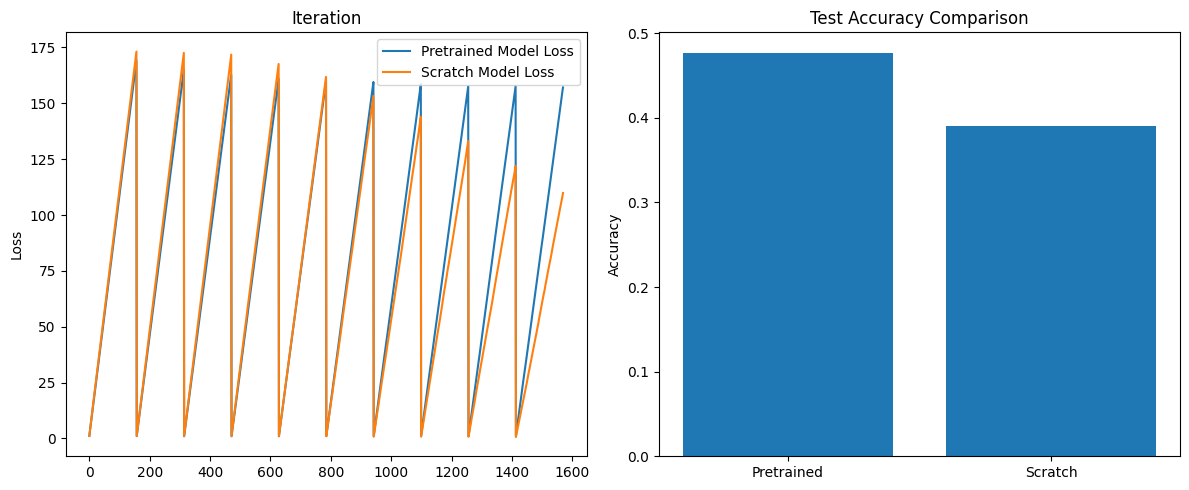

In [16]:
import matplotlib.pyplot as plt

# Loss curve 비교
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pretrained Model Loss')
plt.plot(scratch_losses, label='Scratch Model Loss')
plt.title('Iteration')
plt.ylabel('Loss')
plt.legend()

# Test Accuracy 비교
plt.subplot(1, 2, 2)
plt.bar(['Pretrained', 'Scratch'], [test_acc, scratch_test_acc])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## [LOG] Scratch Model Loss는 더 빨리 감소하지만 이는 일반적인 학습이 잘 되었다기보다는 학습데이터에 알맞게 학습이 되었다는 것을 Test Accuracy를 보면 알 수 있음. 일반적인 상황에서는 성능이 Pretrained보다 좋지 않음
